In [1]:
from datasets import load_dataset, concatenate_datasets
import argparse
from ddpm.denoising_diffusion_pytorch import Unet, GaussianDiffusion, Trainer, Galaxies
import wandb
import torch
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True


%load_ext autoreload
%autoreload 2

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
wandb.init()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: sihany. Use `wandb login --relogin` to force relogin


In [2]:
# meta data
metadata = load_dataset("parquet", data_files="/pscratch/sd/s/sihany/smithgalaxies/galaxies/metadata.parquet", split="train")
meta_sorted = metadata.sort("dr8_id")
# meta_sorted = meta_sorted.with_format("torch", device=DEVICE)


ds = load_dataset("parquet", data_files={'train': '/pscratch/sd/s/sihany/smithgalaxies/galaxies/data/train*'}, split="train[:12%]")

ds = ds.sort("dr8_id")
# ds = ds.with_format("torch", device=DEVICE)
print(len(ds))
ids_train = set(ds['dr8_id'])
meta_train = meta_sorted.filter(lambda example: example["dr8_id"] in ids_train, num_proc = 4)
assert len(meta_train['dr8_id']) == len(ds['dr8_id'])
assert meta_train['dr8_id'] == ds['dr8_id']


# select only rows with good specz
inds = [example is not None for example in meta_train['spec_z']]
import numpy as np
inds = np.arange(len(meta_train))[np.array(inds)]

ds = ds.select(inds)
meta_train = meta_train.select(inds)

# merge datasets
ds = concatenate_datasets([ds, meta_train.select_columns(['spec_z', 'mass_inf_photoz', 'sfr_inf_photoz'])], axis = 1)

Resolving data files:   0%|          | 0/192 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/229 [00:00<?, ?it/s]

1016948


In [18]:
from torchvision import transforms

# send to cuda
ds = ds.with_format("torch", device=DEVICE)

# Preprocessing the datasets and DataLoaders creation.
augmentations = transforms.Compose(
    [
            transforms.CenterCrop((128, 128)),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
    ]
)

def transform_images(examples):
    images = [augmentations(image.convert("RGB")) for image in examples["image"]]
    return {"image": images, "dr8_id": examples['dr8_id'], "spec_z": examples['spec_z'], 
            "mass_inf_photoz": examples['mass_inf_photoz'], "sfr_inf_photoz": examples['sfr_inf_photoz']}

ds.set_transform(transform_images)


In [19]:
ds[0]['image']

tensor([[[-0.4902, -0.2314, -0.3569,  ..., -0.6078, -0.6314, -0.5451],
         [-0.2863, -0.3020, -0.5451,  ..., -0.8745, -0.6157, -0.7804],
         [-0.4902, -0.6314, -0.4039,  ..., -0.7647, -0.6314, -0.7412],
         ...,
         [-0.6078, -0.8118, -0.5294,  ..., -0.5294, -0.4353, -0.5294],
         [-0.7098, -0.8667, -0.5765,  ..., -0.7882, -0.6627, -0.4980],
         [-0.8431, -0.8118, -0.6627,  ..., -0.6314, -0.5765, -0.7647]],

        [[-0.8431, -0.6627, -0.7020,  ..., -0.7490, -0.7725, -0.6235],
         [-0.6078, -0.6235, -0.7804,  ..., -0.9529, -0.6784, -0.7725],
         [-0.6627, -0.7020, -0.3647,  ..., -0.6706, -0.6392, -0.7569],
         ...,
         [-0.7882, -0.9686, -0.6078,  ..., -0.4275, -0.5294, -0.6784],
         [-0.7569, -0.9529, -0.6549,  ..., -0.6863, -0.7412, -0.6706],
         [-0.8118, -0.8588, -0.7647,  ..., -0.5686, -0.6157, -0.8824]],

        [[-0.8196, -0.6157, -0.7255,  ..., -0.8275, -0.8510, -0.7176],
         [-0.6235, -0.6392, -0.8667,  ..., -1

TypeError: Invalid shape (3, 128, 128) for image data

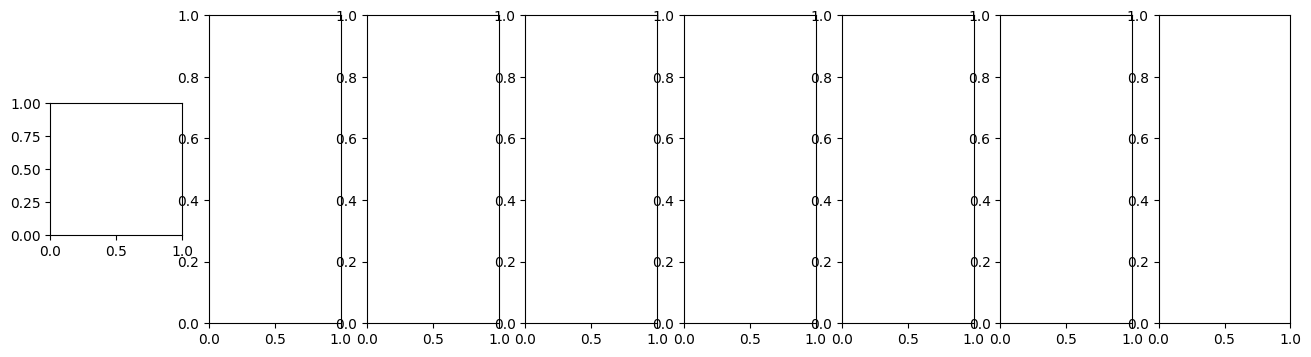

In [20]:
# plot examples
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 8, figsize=(16, 4))
for i, image in enumerate(ds[:8]['image']):
    axs[i].imshow(image.cpu())
    # axs[i].set_xlim(64, 192)
    # axs[i].set_ylim(64, 192)
    axs[i].set_axis_off()
plt.subplots_adjust(wspace=0.05, hspace=0)
fig.show()

In [41]:
# randomly save a bunch of val images for fid scores
from matplotlib.image import imread
from PIL import Image
from tqdm import tqdm 

saveinds = np.random.choice(range(len(ds)), size = 3000, replace = False).astype(int)
for ind in tqdm(saveinds):
    gal = ds[int(ind)]['image'].cpu()
    gal = gal[gal.shape[0]//2 - 64:gal.shape[0]//2 + 64, gal.shape[1]//2 - 64:gal.shape[1]//2 + 64, :]
    im = Image.fromarray(gal.numpy().astype(np.uint8))
    
    im.save(f'/pscratch/sd/s/sihany/logs/tests_specz/{ind}.jpeg')
    

100%|██████████| 3000/3000 [00:16<00:00, 177.38it/s]


In [21]:
from torch.utils import data
dl = data.DataLoader(ds, batch_size = 16, shuffle=True)

In [22]:
model = Unet(
    dim = 64,
    dim_mults = (1, 1, 2, 2, 2, 4, 4, 4),
    # dim_cond = 3
).to(device=DEVICE)

diffusion = GaussianDiffusion(
    model,
    image_size =128,
    timesteps = 1000,
    loss_type = 'l2'
).to(device=DEVICE)

In [23]:
trainer = Trainer(
    diffusion,
    dl = dl,
    logdir = '/pscratch/sd/s/sihany/logs/desi_cond1/',
    image_size = 128,
    train_batch_size = 16,
    train_lr = 1e-4,
    train_num_steps = 100000,         # total training steps
    gradient_accumulate_every = 1,    # gradient accumulation steps
    ema_decay = 0.995,                # exponential moving average decay
    step_start_ema = 5000,
    save_every = 5000,
    sample_every = 3000,
    num_workers=16,
    cond = False,
)

In [24]:
trainer.train()

  0%|          | 0/100000 [00:00<?, ?it/s]

torch.Size([16, 3, 128, 128]) tensor([[[[-0.8353, -0.7333, -0.5686,  ..., -0.7882, -0.6157, -0.6706],
          [-0.6706, -0.7412, -0.7176,  ..., -0.7412, -0.7647, -0.6784],
          [-0.5608, -0.7098, -0.6627,  ..., -0.7882, -0.9137, -0.7804],
          ...,
          [-0.8588, -0.8980, -0.7412,  ..., -0.6941, -0.8039, -0.8745],
          [-0.8353, -0.8980, -0.7412,  ..., -0.8118, -0.8431, -0.7804],
          [-0.8275, -0.8275, -0.5686,  ..., -0.7020, -0.8824, -0.6941]],

         [[-0.8275, -0.8196, -0.7569,  ..., -0.7490, -0.6392, -0.7333],
          [-0.6000, -0.7647, -0.8902,  ..., -0.7176, -0.8118, -0.7490],
          [-0.4275, -0.6157, -0.6627,  ..., -0.8353, -0.9059, -0.7176],
          ...,
          [-0.9059, -0.9294, -0.8353,  ..., -0.6627, -0.6784, -0.7333],
          [-0.7725, -0.8902, -0.8667,  ..., -0.8980, -0.7647, -0.6941],
          [-0.7725, -0.8196, -0.7020,  ..., -0.8275, -0.8745, -0.6706]],

         [[-0.9529, -0.8667, -0.6471,  ..., -0.8039, -0.6941, -0.7490],


loss = 1.2200927734375:   0%|          | 0/100000 [00:02<?, ?it/s]


Error: You must call wandb.init() before wandb.log()

In [8]:
import numpy as np
from PIL import Image
import os

milestone = 300000
trainer.load(milestone)
fakedir = '/pscratch/sd/s/sihany/logs/fakes/'+str(milestone)+'/'
if not os.path.exists(fakedir):
    os.makedirs(fakedir)
    
batchsize = 500
for i in range(0, 6):
    all_images = trainer.ema_model.module.sample(128, batch_size = batchsize)
    
    all_images = (all_images + 1)/2
    # all_images = list(map(lambda x: (x - 0)/(255 - 0), all_images))
    all_images = torch.flip(all_images, dims=[1])*255 # map channels correctly for imout
    all_images = all_images.round()
      
    for eid, im in enumerate(all_images):
        im = Image.fromarray(im.cpu().numpy().astype(np.uint8).T)
        im.save(fakedir+str(eid+i*batchsize)+".jpeg")


sampling loop time step: 100%|██████████| 1000/1000 [08:07<00:00,  2.05it/s]


In [ ]:
# check to see if 40,000 steps model is good enough, current training time for 100000 is 6 hours
# fid score went from 37 to 57. so 40,000 is definitely not good enough
# lets try 75000, fid = 41, so the fid is definitely steadily going down as we train more 
# what if we train for even longer, that test is done below with the dim = 64 model

In [9]:
!python -m pytorch_fid --device cuda:2 --batch-size 100 /pscratch/sd/s/sihany/logs/tests2 /pscratch/sd/s/sihany/logs/fakes/300000

100%|███████████████████████████████████████████| 30/30 [00:01<00:00, 17.41it/s]
FID:  33.07824874974605


In [ ]:
# fid score 37. the same as the other dataset
# now drop unet dim from 128 to 64, train 120000 steps, fid = 37.8. so dim = 64 is probably enough. Now training to 210000 steps, we have 34.5, training to 300000 steps, we have 33. 